# Apply Neural Networks to the Stock Market

Notebook to explore limited set of NY stock exchange data over around 40 years, as part of the Portland Data Science group (Mar 2018).
Data selected by Matt Borthwick from Yahoo! Finance.
Working with Neural Network group: Matt, John Burt, Manny, Isil, Kenny, Jhoan, Mark C.

Our goal is to predict weekly returns on 6 industry based ETFs, as well
as aggregate market performance (such as Russel3000).  We will also
be using some macroeconomic indicators as well.
This notebook currently loads the data, transforms it, and applies a
simple neural network to try predicting the next days stock prices.
The first model was built in tensorflow (and is currently broken).  THere is a second network written in Keras.

The plan is to train on this data (up to Sep 2017),
validate on (Oct-Dec 2017), and test in final session on (Jan-Mar 2018).

(For more exploratory screwing around, and other attempts at time-series see PDX_finance1)

Currently Contains:
-Colab setup
-Loading data
-Tensorflow RNN (currently borked at prediction stage - wrong size? No idea what changed)
-Keras RNN  (not working yet)
-Keras Deep network

# Google Colab setup

First up however, we need to install modules to load up our google drive for storage.  (Code taken from this helpful post https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d)
(Code and commands didn't look sketchy/malicious, but I didn't examine the PPA too closely either.)

This code is for execution inside a Jupyter notebook on colab.google.com.
It gives Colab access to your Google Drive in order to load/save data from within the notebook.
Colab has most popular libraries (numpy, pandas, tensorflow, matplotlib).  I'm not sure how extensive it is.

I've found opening a jupyter notebook on google drive automatically opens the Colab.

In [ ]:
#Install modules on local machine.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!echo 'past update'
!apt-get -y install -qq google-drive-ocamlfuse fuse
!echo 'installed fuse'

In [ ]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
print('past first command')
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
#Mounts google drive, and changes to that directory
!mkdir -p drive 
!google-drive-ocamlfuse drive

import os
os.chdir("drive")

#Should now be in the root of your google-drive, and now free to load/save existing files.

# Load Libraries and Data

Now to load libraries, and data for all stocks, ETFs, and indicators.
All of those will get stuck together into one total dataframe.
(This is where I start my analysis on my home machine.)

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# automatically reload files.
%load_ext autoreload
%autoreload 2

In [2]:
#Data compiled from Yahoo! Finance data by Matt Borthwick
df_close=pd.read_csv('data/stocks-us-adjClose.csv',index_col=0,parse_dates=True)
df_high=pd.read_csv('data/stocks-us-adjHigh.csv',index_col=0,parse_dates=True)
df_low=pd.read_csv('data/stocks-us-adjLow.csv',index_col=0,parse_dates=True)
df_vol=pd.read_csv('data/stocks-us-Volume.csv',index_col=0,parse_dates=True)
df_close.index.name='date'
df_high.index.name='date'
df_low.index.name='date'
df_vol.index.name='date'

In [3]:
df_market=pd.read_csv('data/market.csv',index_col=0,parse_dates=True)
df_etf = pd.read_csv('data/sector_ETFs.csv',index_col=0,parse_dates=True)
df_comp_info=pd.read_csv('data/Company_information.csv',encoding='latin1')


In [4]:
#join russell, and ETFs together, then to the stocks.
df_target=pd.DataFrame.join(df_market,other=df_etf,how='outer')
df_tot=df_close.join(df_target,how='inner')

In [5]:
#got this from earlier reading in.
df_ind_col=['Date_orig', 'HOUST', 'HOUST_dt', 'UNRATENSA', 'UNRATENSA_dt', 'EMRATIO',
       'EMRATIO_dt', 'UEMPMED', 'UEMPMED_dt', 'UMCSENT', 'UMCSENT_dt',
       'USSLIND', 'USSLIND_dt', 'KCFSI', 'KCFSI_dt', 'IPMAN', 'IPMAN_dt',
       'VIXCLS', 'VIXCLS_dt', 'DGS10', 'DGS10_dt']

In [5]:
##Pieter Leffer's code for reading in indicators
import csv

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# I ran into errors importing the file because of non-ascii characters in the heading
#Here is a piece of code I got from stack overflow to fix that problem.
df_ind=[]
with open('data/Indicators_Train.csv', newline='', encoding='utf-8', errors='ignore') as f:
    reader = csv.reader(f)
    for row in reader:
        df_ind.append(row)

df_ind=pd.DataFrame(df_ind)
df_ind.columns=df_ind.iloc[0]
Column_Reference=df_ind.iloc[1].copy()
#Drop useless rows (last row is empty)
df_ind.drop([0,1],inplace=True)

#Change the formatting of the variables. Datetime to the ones for dates, integers for the ones that aren't
for i in range(0,len(df_ind.columns)):
    if i % 2 == 0:
        df_ind[df_ind.columns[i]] = pd.to_datetime(df_ind[df_ind.columns[i]], format = '%m/%d/%Y',  errors='coerce') 
    else:
        df_ind[df_ind.columns[i]] = pd.to_numeric(df_ind[df_ind.columns[i]], errors='ignore')
        
#Reset the index because we dropped rows in the DataFrame, Using the drop command to remove the old index
df_ind.reset_index(drop=True, inplace=True)

#make a time index too.
df_ind.index=pd.DatetimeIndex(df_ind['date'])
#drop those time columns
Nind=10

In [7]:
#keep numbers of values
Nstocks_tot=df_close.shape[1]
Netf=7
Nind=10

In [8]:
join_num=np.arange(1,len(df_ind.columns),2)
df_tot=df_tot.join(df_ind.iloc[:,join_num],how='inner')

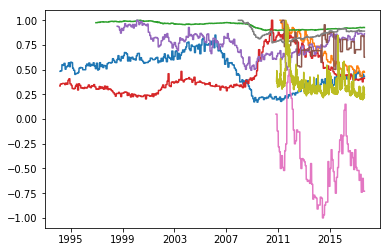

In [211]:
#Plots the scaled values of the economic indictors.
sl=slice(1,-2,2)
df_ind_scale=df_ind.iloc[:,sl].abs().max()
cutoff=int(len(df_ind)/2)
plt.plot(df_ind.iloc[cutoff:,sl]/df_ind_scale)
plt.show()

In [51]:
df_tot.columns

Index(['ED', 'DD', 'CVX', 'FL', 'CAT', 'IP', 'SJW', 'F', 'LLY', 'AVP',
       ...
       'HOUST', 'UNRATENSA', 'EMRATIO', 'UEMPMED', 'UMCSENT', 'USSLIND',
       'KCFSI', 'IPMAN', 'VIXCLS', 'DGS10'],
      dtype='object', length=727)

Looking at the number of NA values (summed across columns) suggests that
there are missing values in these stocks.

Could set all NA to zero, then apply linear interpolation to handle isolated
missing days.  Let's check the pattern of missing days.

In [9]:
#Plot pattern of NA values.  Weird stripes?
plt.figure(figsize=(10,6))
col=df_close.columns[0:]
plt.imshow(np.isnan(df_vol.loc['2000':,col]),aspect='auto')
plt.show()

So, some stopped stocks, and one out of place one where 

# Neural Network

This model is just a test based purely on the stock data.
The network uses a multi-layer RNN, with two hidden layers at input/output.  They use leaky ReLU activation.
The model currently plays with 100 stocks from 2002-2006.

This uses a model I've cobbled together in Tensorflow.
The OO structure is borrowed from the online problem sets
from CS224 on NLP offered in 2017 at Stanford.
The NN is borrowed from A. Geron "Hands on Machine Learning with Scikit-Learn and Tensorflow", which I've found to be the best
overall introduction, and has a good mix of background, and code.
(There is also an associated Github account with code).

The Tensorflow docs were pretty hard reading, and there seem to be lots
of tricks that only practitioners on StackOverflow are aware of.  (But the tutorials are pretty readable.)

Note network currently only predicts one timestep into the future. 


In [10]:
import tensorflow as tf
from recurrent_network import recurrent_NN

# Data Transformation

For the initial testing, I'm just building a model based on the 100 oldest stocks (or whichever come first), and looking at 2002-2006.
Why then?  Because it looks relatively well behaved.
The model is trained on the first half of the data, and we then run the
network on the whole data set.

I'm currently just taking the base-10 log of the data, and scaling each
stock to lie with [-1,1].  I found differencing the data lead to
pretty crappy results (then again, these are also pretty crap results).

So there's some choices to be played with here:
- scaling: variance vs max/min
- differencing?

In [12]:
Nstocks=300
Xsub=df_tot['2000':'2006'].iloc[:,:Nstocks].values

def scale_clean_data(X):
    #set missing values to zero.  (to avoid issues in network with NaNs)
    X[np.isnan(X)]=0
    #take differences of logs. (shift zero to avoid NANs)
    #Xsub2 = np.diff(np.log10(Xsub+1E-12),axis=0)
    X = np.log10(Xsub+1E-16)

    X_max = np.max(X,axis=0)
    X_min = np.min(X,axis=0)

    #Choice of scaling here: max/min vs variance?
    #I think variance makes more sense if differencing.
    rng = 0.5*(X_max-X_min)
    avg = 0.5*(X_max+X_min)
    Xscaled= (X-avg)/rng
    return Xscaled,rng,avg

Xsub2,rng,avg=scale_clean_data(Xsub)

#split 3/4 as training, 1/4 as test
N=len(Xsub2)
Nc=int(3*N/4)
#make training/test splits
Xtrain = Xsub2[:Nc]
ytrain = Xsub2[1:Nc+1] #tomorrow's return.

Xtest=Xsub2[Nc:-1]
ytest=Xsub2[Nc+2:]

In [13]:
#check scaling
plt.figure()
plt.plot(Xtrain[:,0:5])
plt.plot(ytrain[:,0:5])
plt.show()

# Fitting RNN

In [14]:
#define network.
#Note a lot of network parameters are defined in __init__ in "recurrent_network.py".
#A more robust structure would pass a config dict or something like that.
RNN=recurrent_NN(60,Nstocks,100,Nstocks,'LSTM')

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 100) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 100) dtype=float32>))
Tensor("strided_slice:0", shape=(2, ?, 300), dtype=float32)


In [15]:
#Rebuild the tensorflow graph.
RNN.build()
#Actually train the graph on first half of data.
#Give all of the data to this subroutine, where it selects
# the inputs and target data in get_random_batch

RNN.train_graph(Xtrain,Xtrain,save_name='tf_models/rnn_test')
#Note the tiny, tiny errors.  Probably badly overfitting.
#Need to fix the dropout so it's only on in training.

iter #20. Current MSE:0.22016216814517975
Total Time taken:21.250980377197266




KeyboardInterrupt: 

In [19]:
%pdb on

Automatic pdb calling has been turned ON


In [20]:
#Predict on all of the data.
#This loads up a previous model.
RNN_pred=RNN.predict_all('tf_models/rnn_test',20,Xsub2,reset=True)

INFO:tensorflow:Restoring parameters from tf_models/rnn_test-20
0 100


ValueError: could not broadcast input array from shape (2,100,300) into shape (100,300)

> /home/jonathan/Data-Science/PDX_DataScience/PDX_finance/recurrent_network.py(369)predict_all()
    367                 X_batch[i,:,:]=input_data[(i0+i):(i0+i+self.Nsteps),:]
    368             nn_pred=self.predict_on_batch(sess,X_batch)
--> 369             nn_pred_total[-Nleft:]=nn_pred
    370             #nn_pred_reduced=np.round(nn_pred_total).astype(bool)
    371         return nn_pred_total



ValueError: could not broadcast input array from shape (2,100,300) into shape (100,300)

In [11]:
def plot_pred(X,pred,indx_range):
    """Plots a particular stock and the prediction"""

    plt.figure()
    plt.subplot(121)
    plt.plot(X[:,indx_range])
    plt.plot(pred[:,indx_range])
    plt.plot([len(X)/2]*2,[-1,1],'k-')
    plt.legend(['Actual','Forecast'])
    plt.title('Raw')

    plt.subplot(122)
    plt.plot(np.cumsum(X[:,indx_range],axis=0))
    plt.plot(np.cumsum(pred[:,indx_range],axis=0))
    plt.legend(['Actual','Forecast'])    
    plt.title('Cumulative')

    plt.show()
    

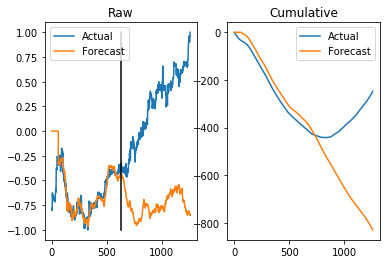

In [17]:
#Could make predicted results a time series for nicer formating, and dates.
#Plot cumulative for cases when we've also differenced.
plot_pred(Xsub2,RNN_pred,50)

This RNN forecast is also WAY worse than a persistence forecast (tomorrow's price is the same as todays).
Big question: why is the price wandering away? Even if the model is fixed (weights unchanged), surely it should take the recent past (which the model uses to forecast tomorrow's demand) into account.  

Note the effect of further smoothing, which suggests a clearer trend, that might be easier to model.
That suggests the convolutional networks may be useful,
perhaps with running averages to smooth the data.  Forecasting on a week timescale might allevative some of that too?

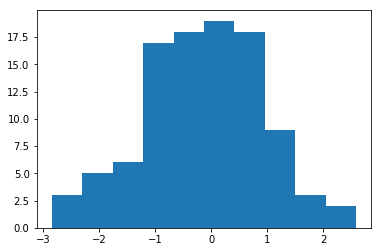

In [13]:
#Let's look at the differences between the predicted and actual
#results at the end of the period.
pred_diff=RNN_pred[-1]-Xsub2[-1]
plt.hist(pred_diff)
plt.show()

In [15]:
(np.mean(pred_diff),np.std(pred_diff))

(-0.1433746024133806, 1.0660086500156463)

In [104]:
#Let's now see how much the predictions vary (across all stocks) at the end of training, 20 trading days after that,
# and at the end of the period, a year or two out.

#Note that these predictions use the data from those periods, but the model is not being updated.

def plot_err_hist(target,pred,Nc):
    '''plot_err_hist

    Makes histograms of the errors between the target and prediction
    at multiple time scales aroud the tend of the training period.
    '''
    
    Nc = int(len(Xsub2)/2)
    plt.figure(figsize=(10,6))

    plt.subplot(141)
    pred_diff=pred[Nc-20]-target[Nc-20]
    plt.title('End of training - 20 days')
    plt.hist(pred_diff)

    plt.subplot(142)
    pred_diff=pred[Nc]-target[Nc]
    plt.title('End of training')
    plt.hist(pred_diff)

    plt.subplot(143)
    pred_diff=pred[Nc+20]-target[Nc+20]
    plt.title('End of training+20 days')
    plt.hist(pred_diff)

    plt.subplot(144)
    pred_diff=pred[-1]-target[-1]
    plt.hist(pred_diff)
    plt.title('End of test')
    plt.xlabel('Forecast Residuals')
    plt.show()


The final graph is worst, it is also trying to predict many years ahead, based on essentially short-term info.
Probably could describe build up of cumulative errors as a random walk?
Would guess errors grows as sqrt(T), so the variance of this distribution grows as T.


# Keras Network

Let's build a similar recurrent network in Keras (just using the adjusted close for now). 

The goal is to predict the a whole quarters worth of weekly returns on 6 sectors, denoted by $\mathbf{y}_{t}$, based on a sequence of inputs $\mathbf{x}_{t}$, which can be (stocks, previous values of the inputs, macroeconomic indicators ).

We will use a recurrent network, which should map a whole sequence of previous inputs to another sequence of output vectors.
\begin{equation}
  \hat{y}_{t+n} = RNN(\mathbf{x}_t,\mathbf{x}_{t-1},\ldots \mathbf{x}_{t-\tau})
\end{equation}
where $\tau$ is the maximum period we look back over, and $n$ is the number of periods we are looking forward over.

Ideally, we would use all output times together to predict the outputs.
I think a reshape is in order here?

The LSTM will make a bunch of predictions for each time step (we will forecast fewer time steps than we input).


In [21]:
#Borrowing some from Keras docs, and "https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/"
import keras  
from keras.models import Sequential 
from keras.layers import Dense, RNN, LSTM, StackedRNNCells, Reshape, Dropout
from keras.losses import mean_squared_error, mean_absolute_error
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [22]:
Nstocks=100
Nfeature=1
Ninput=Nstocks*Nfeature+Netf+Nind
Noutput=Netf
#number of times in/out.
Ntime_in=200
Ntime_out=60
#network parameters
Nhidden=50
Nlayers=1
dropout_frac=0
Nepoch=100
Nbatch=100
Nprint=20


In [32]:
def scale_maxmin(X):
    '''scale_maxmin

    Scales each column by taking log, and max/min scaling.
    Only take the log for the stock/etf data.
    '''
    #set missing values to zero.  (to avoid issues in network with NaNs)
    X[np.isnan(X)]=0    
    #take differences of logs. (shift zero to avoid NANs)
    #Xsub2 = np.diff(np.log10(Xsub+1E-12),axis=0)
    X[:,:-Nind] = np.log10(X[:,:-Nind]+1E-16)

    X_max = np.max(X,axis=0)
    X_min = np.min(X,axis=0)
    #Choice of scaling here: max/min vs variance?
    avg = 0.5*(X_max+X_min)
    rng = 0.5*(X_max-X_min)
    Xscaled= (X-avg)/rng
    Xscaled[np.isnan(Xscaled)]=0
    return Xscaled,rng,avg

def scale_diff_var(X):
    """scale_diff_var
    Scales each column by taking log, then differencing.
    Then scales to have zero mean, and unit standard deviation..
    Only take the log for the stock/etf data.
    """
    #set missing values to zero.  (to avoid issues in network with NaNs)
    X[np.isnan(X)]=0
    #take differences of logs. (shift zero to avoid NANs)
    X[:,:-Nind] = np.diff(np.log10(X[:,:-Nind]+1E-16),axis=0)
    X_std = np.std(X,axis=0)
    X_mean = np.mean(X,axis=0)
    Xscaled= (X-X_mean)/X_std
    Xscaled[np.isnan(Xscaled)]=0    
    return Xscaled,X_mean,X_std

In [26]:
plt.figure()
plt.plot(Xsub_scale[:,-Nind:])
plt.show()

In [273]:
Xsub=df_tot.loc['2000':'2005'].values
method='maxmin'
# if (method=='differencing'):
#     Xsub_scale,Xrng,Xavg=scale_diff_var(Xsub)
# else:
Xsub_scale,Xrng,Xavg=scale_maxmin(Xsub)

#split 3/4 as training, 1/4 as validation
N=len(Xsub_scale)
Nc=int(3*N/4)

#select out desired range of columns for training (stocks, etf, ind)
N0=Nstocks
ind_stock=np.arange(Nstocks)
#pull out ETFS
N0=Nstocks_tot
N1=N0+Netf
ind_etf=np.arange(N0,N1)
#pull out indicators
N0=Nstocks_tot+Netf
N1=N0+Nind
ind_ind=np.arange(N0, N1)
#combine out values to use in 
ind_x=np.append(ind_stock,ind_etf)
ind_x=np.append(ind_x,ind_ind)

#make training/test splits
#train on stock, indicators and ETFs.
Xtrain = Xsub_scale[:Nc,ind_x]
ytrain= Xsub_scale[:Nc,ind_etf]

I had hoped Keras would automatically take care of random temporal batching like this, but unfortunately it does not.
So, this routine which randomly selects a batch of indices to start fitting at.  

In [34]:
#note: this relies on looking up global parameters (blech)
def get_rnn_batch(X,y):
    """get_rnn_batch
    Returns a randomly selected batch of input/output sequences.
    Inputs are all stocks, ETFs and indicators
    Outputs are just future ETFs from input sequence endpoint.
    """
    #starting indices
    ind=np.arange(len(X[:,0])-Ntime_in-Ntime_out)
    rand_ind=np.random.choice(ind,Nbatch,replace=False)
    Xb=np.zeros((Nbatch,Ntime_in, Ninput))
    yb=np.zeros((Nbatch,Ntime_out,Noutput))
    #now populate table (couldn't see nice way to vectorize this assignment, mabe via overloading)
    for i in range(Nbatch):
        t0=rand_ind[i]
        t1=t0+Ntime_in
        t2=t1+Ntime_out
        #input all past parameters
        Xb[i]=X[t0:t1]
        #target future ETFs
        yb[i]=y[t1:t2]
    return Xb,yb

## Making the Network

The following makes a 4 layer network - a dense layer at input with linear activation to reduce dimension,
followed by two recurrent layers (using a LSTM for longer memory),
and a final dense layer to map from the hidden units to the final outputs.
The LSTMs can use "leaky ReLU" activation, which are suited to long sequences since the gradients dont explode, or go to zero.
The output sequences are then flattened, before being put through
a final linear layer to add together the results.
(In a fancy version this could be a CNN?)
The final result is reshaped again to output a batch of sequences.

The Adam optimizer is basically a fancy version of gradient descent (with a momentum, scaling based on previous updates, and learning rate scheduling)

In [35]:
#make a Keras model two layer LSTM, with dense input/outputs
#Use the sequence-to-sequence example.  
def make_deep_RNN(activ='relu'):
    keras.backend.clear_session()
    model=Sequential()
    model.add(Dense(units=Nhidden, activation='linear', input_shape=(Ntime_in,Ninput))) #linear mapping at input
    if (activ=='relu'):
        act = keras.layers.advanced_activations.LeakyReLU(alpha=0.1)               
        for n in range(Nlayers-1):
            model.add(Dropout(rate=dropout_frac, noise_shape=(Nbatch,1,Nhidden))) #dropout at input                
            model.add(LSTM(units=Nhidden,activation='linear',return_sequences=True))
            model.add(act)            #add extra activation layer afterwards
            #final LSTM layer
        model.add(Dropout(rate=dropout_frac, noise_shape=(Nbatch,1,Nhidden))) #dropout at input                            
        model.add(LSTM(units=Nhidden,activation='linear',return_sequences=True))
        model.add(act)
    else:
        for n in range(Nlayers-1):
            #first LSTM layer
            model.add(Dropout(rate=dropout_frac, noise_shape=(Nbatch,1,Nhidden))) #dropout at input                                        
            model.add(LSTM(units=Nhidden,activation=activ,return_sequences=True))
            #add extra activation layer afterwards
        model.add(Dropout(rate=dropout_frac, noise_shape=(Nbatch,1,Nhidden))) #dropout at input                                        
        model.add(LSTM(units=Nhidden,activation=activ,return_sequences=True))
    #flatten that sequence of outputs down.           
    model.add(Reshape(input_shape=(Ntime_in,Nhidden), target_shape=(Ntime_in*Nhidden,)))
    #linear mapping to reduce/increase dimension at output
    model.add(Dense(units=Noutput*Ntime_out, activation='linear', input_shape=(Ntime_in*Nhidden,))) 
    #reshape again that sequence down.           
    model.add(Reshape(input_shape=(Noutput,), target_shape=(Ntime_out,Noutput)))
              
    model.compile(optimizer='adam',loss=mean_squared_error)
    return model

def train_model(model,Xtrain,ytrain):
    for i in range(Nepoch+1):
        Xb,yb=get_random_batch(Xtrain,ytrain)
        if (i)%Nprint==0:
            model.fit(Xb,yb, epochs=1,batch_size=Nbatch,verbose=1)
        else:
            model.fit(Xb,yb, epochs=1,batch_size=Nbatch,verbose=0)
        model.reset_states()
    return model

def predict_from_model(model,X):
    #Predict on whole of this subset (both "training" and "testing")
    Nf = len(X)-Ntime_in-Ntime_out
    ypred_tot=np.zeros((Nf,Noutput))
    yavg = np.zeros(Nf)
    i0=0
    i1=i0+Nbatch
    #split whole time sequence into sequential batches.
    while (i1 < Nf):
        X0=np.zeros((Nbatch,Ntime_in,Ninput))
        for i in range(Nbatch):
            X0[i]=X[i0+i:i0+i+Ntime]
        ypred=model.predict(X0,batch_size=Nbatch)
        #now march along batch, add up predictions.    
        for i in range(Nbatch):
            ypred_tot[Ntime_in+i0:Ntime_in+i0+Ntime_out]+=ypred[i]
            yavg[Ntime_in+i0:Ntime_in+i0+Ntime_out]+=1
        model.reset_states()    
        i0=i1
        i1+=Nbatch
    #predict on the remainder
    Nrem=Nf-i0
    X0=np.zeros((Nrem,Ntime,Ninput))
    for i in range(Nrem):
        X0[i]=X[i0+i:i0+i+Ntime]
    ypred=model.predict(X0,batch_size=Nrem)
    #now march along batch, add up predictions.    
    for i in range(Nrem):
        ypred_tot[Ntime_in+i0:Ntime_in+i0+Ntime_out]+=ypred[i]
        yavg[Ntime_in+i0:Ntime_in+i0+Ntime_out]+=1
        
    ypred_tot=ypred_tot/yavg    
   
    return ypred_tot


## Training the Network

Now run in minibatches.  The "if" statement means we only see the output every 50 iterations.
The "reset_states()" call should reset the internal state of the model.
Note that the reported loss is the loss (MSE) on the current batch.  

In [38]:
%pdb off

Automatic pdb calling has been turned OFF


In [36]:
rnn_model=make_deep_RNN(activ='linear')

In [37]:
rnn_model=train_model(rnn_model,Xtrain,ytrain)

Epoch 1/1
100/100 [==============================] - 2s 21ms/step - loss: 2550985356476416.0000


KeyboardInterrupt: 

> /home/jonathan/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py(1302)_run_fn()
   1300           return tf_session.TF_Run(session, options,
   1301                                    feed_dict, fetch_list, target_list,
-> 1302                                    status, run_metadata)
   1303 
   1304     def _prun_fn(session, handle, feed_dict, fetch_list):



KeyboardInterrupt: 

In [322]:
ypred=predict_from_model(model,Xsub_scale)

ValueError: could not broadcast input array from shape (10,727) into shape (200,117)

## Predicting the whole sequence

This runs the network on the whole subset of data we've pulled out from 2000 to 2008.  This checks performance on both the training data,
as well as the holdout data.  As we'll see, the performance drops precipitously once training ends.   

In [35]:
def plot_predictions(X,ytarget,ypred,Nplot_start,skip):
    Nplot_end=Nplot_start+skip
    plt.figure(figsize=(20,12))
    legend_list=[]

    Ntime,Nstocks=X.shape
    #plot prediction    
    for i in range(Nplot_start,Nplot_end):
        j = i-Nstocks;
        if (method=='differencing' or method=='roll_avg_diff'):
            plt.plot(np.cumsum(ypred[:,i],axis=0),'--')
        else:
            plt.plot(ypred[:,i],'--')
        if (np.abs(j)>7):
                legend_list.append(df_tot.columns[i]+'-pred')
        else:
                legend_list.append(df_tot.columns[j]+'-pred')
               
    #plot actual    
    for i in range(Nplot_start,Nplot_end):
        j = i-Nstocks;    
        if (method=='differencing' or method=='roll_avg_diff'):
            plt.plot(np.cumsum(ytarget[:,i],axis=0),'--')
        else:
            plt.plot(ytarget[:,i],'-.')

        if (np.abs(j)>7):
                legend_list.append(df_tot.columns[i]+'-target')
        else:
                legend_list.append(df_tot.columns[j]+'-target')
    plt.plot([Nc,Nc],[-1,1],'k')    
    plt.legend(legend_list,bbox_to_anchor=(1,1))
    plt.show()

In [20]:
ypred=predict_from_model(model,Xsub_scale)

In [26]:
ypred.shape,ytot.shape

((2505, 307), (2515, 307))

In [37]:
plot_predictions(Xsub_scale,ytot,ypred,300,1)

In [164]:
#plot errors
plt.figure()
Nplot_start=0
Nplot_end=2
legend_list=[];
for i in range(Nplot_start,Nplot_end):
    plt.plot(ypred[:,i]-ytot[Nahead:-Nahead,i])
    legend_list.append(df_target.columns[i])
plt.title('Model Errors over time')
plt.legend(legend_list,bbox_to_anchor=(1,1))
plt.show()

In [232]:
plot_err_hist(Xsub_scale,Nc)

NameError: name 'plot_err_hist' is not defined

So, the model is doing terribly.  I thought it would at least track the correct price (and get the directions wrong).
As is, the resulting predictions are wandering far away from the actual price, even when given the correct price data.

Does this make sense?  Under one point of view, these variables are all random walks.  Even if they are correlated,
then, we can find some independent variables which are also given by random walks.  We're fitting a neural network with
memory, and training it to fit this noise.  And when fed new noise, the results are wandering away from the prediction.


# Simple Deep Network

Let's try just making a really wide network.  With all inputs and times at once, and predicting all outputs at once.

Making this work does require lots of reshaping inputs/outputs from 2D to 1D.
I've put this in an OOP structure to try and maintain some hygiene due to multiple models using the same data.
I hope I've caught all of the bugs from when this was just a script.

In [62]:
a=np.arange(9)
A=np.reshape(a,(3,3))

In [350]:
#make a Keras model simple wide, with dense input/outputs.
class deep_network(object):
    Netf=7
    Netf=10
    def __init__(self):
        """Defines all of the local network parameters"""
        self.Nstocks=100
        self.Nfeature=1
        #number of times in/out.
        self.Ntime_in=130
        self.Ntime_out=65
        #total linear input/outputs
        self.Ninput=(self.Nstocks*self.Nfeature+Netf+Nind)*self.Ntime_in
        self.Noutput=Netf*self.Ntime_out
        #network parameters
        self.Nhidden=20
        self.Nlayers=2
        self.dropout_frac=0.2
        self.Nepoch=400
        self.Nbatch=100
        self.Nprint=20
        self.train_frac=0.5
        keras.backend.clear_session()
        self.model=Sequential()

    def make_network(self,activ='relu'):
        """make_network
        Makes a deep multilayer network with dropout.
        Relies on flattened arrays in time as input and output.
        So inputs will use something like X.reshape(-1).
        And outputs will also need reshape back to form (Ntime_out,Nout)
        """
        self.model.add(Dense(units=self.Nhidden, activation='linear', input_shape=(self.Ninput,))) #linear mapping at input
        if (activ=='relu'):
            act = keras.layers.advanced_activations.LeakyReLU( alpha=0.1)               
            for n in range(self.Nlayers):
                self.model.add(Dropout(rate=self.dropout_frac, noise_shape=(self.Nbatch,self.Nhidden))) 
                self.model.add(Dense(units=self.Nhidden,activation='linear'))
                #add extra activation layer afterwards
                self.model.add(act)
        else:
            for n in range(self.Nlayers):
                self.model.add(Dropout(rate=self.dropout_frac, noise_shape=(self.Nbatch,self.Nhidden))) 
                self.model.add(Dense(units=self.Nhidden,activation=activ))

        #final linear mapping at output
        self.model.add(Dense(units=self.Noutput,activation='linear',input_shape=(self.Nhidden,))) #output layer
        self.model.compile(optimizer='adam',loss=mean_squared_error)

    def get_training_data(self,Xsub_scale):
        """get_training_data
        Selects out a subset of the training data.
        Requires monkey around with column indices as input data is of form:
        [ ...stocks..., ETFS, Indicators ]
        Those last two are static, and known.
        Picks out a fraction of the input data and trains the rest on that. 
        """
        #select out desired range of columns for training (stocks, etf, ind)
        N0=self.Nstocks
        ind_stock=np.arange(self.Nstocks)
        #pull out ETFS
        N0=Nstocks_tot
        N1=N0+Netf
        ind_etf=np.arange(N0,N1)
        #pull out indicators
        N0=Nstocks_tot+Netf
        N1=N0+Nind
        ind_ind=np.arange(N0, N1)
        #combine out values to use in 
        ind_x=np.append(ind_stock,ind_etf)
        ind_x=np.append(ind_x,ind_ind)

        #make training/test splits
        #train on stock, indicators and ETFs.
        Xtrain = Xsub_scale[:Nc,ind_x]
        ytrain= Xsub_scale[:Nc,ind_etf]
        return Xtrain,ytrain,ind_x
        
    def get_batch(self,X,y):
        """get_batch
        Returns a randomly selected batch of input/output sequences.
        Inputs are all stocks, ETFs and indicators
        Outputs are just future ETFs from input sequence endpoint.
        """
        #starting indices
        ind=np.arange(len(X[:,0])-self.Ntime_in-self.Ntime_out)
        rand_ind=np.random.choice(ind,self.Nbatch,replace=False)
        Xb=np.zeros((self.Nbatch,self.Ninput))
        yb=np.zeros((self.Nbatch,self.Noutput))
        #now populate table (couldn't see nice way to vectorize this assignment, mabe via overloading)
        for i in range(self.Nbatch):
            t0=rand_ind[i]
            t1=t0+self.Ntime_in
            t2=t1+self.Ntime_out
            #input all past parameters
            Xb[i]=X[t0:t1].reshape(-1)
            #target future ETFs
            yb[i]=y[t1:t2].reshape(-1)
        return Xb,yb,rand_ind

    def train_model(self,Xtrain,ytrain):
        """train_model
        Grabs random sub-batches of data, then trains.
        Uses two different calls to suppress output.
        """
        for i in range(self.Nepoch+1):
            #Keras assumes you have a list of X,y pairs for its sampling.
            #Would be memory intensive to set up a whole list for this data.
            #So wrote my own batching.
            Xb,yb,_=self.get_batch(Xtrain,ytrain)
            if (i)%self.Nprint==0:
                self.model.fit(Xb,yb, epochs=1, batch_size=self.Nbatch, verbose=1)
            else:
                self.model.fit(Xb,yb, epochs=1, batch_size=self.Nbatch, verbose=0)
            self.model.reset_states()

    def predict_from_model(self,X):
        """predict_from_model

        Currently runs all prediction on the given input X.  
        Also currently takes a naive AVERAGE(!) over all of the output predictions. 
        """
        #Predict on whole of this subset (both "training" and "testing")

        #compute total number of predictions to be made. 
        Nf = len(X) - self.Ntime_in - self.Ntime_out
        ypred_tot=np.zeros((len(X),Netf))
        yavg = np.zeros((len(X),1))
        i0=0
        i1=i0+self.Nbatch
        #split whole time sequence into sequential batches.
        while (i1 < Nf):
            X0=np.zeros((self.Nbatch,self.Ninput))
            for i in range(self.Nbatch):
                t0=i0+i
                t1=t0+self.Ntime_in
                X0[i]=X[t0:t1].reshape(-1)
            ypred=self.model.predict(X0,batch_size=self.Nbatch)
            #now march along batch, add up predictions.    
            for i in range(self.Nbatch):
                t0=self.Ntime_in+i0+i
                t1=t0+self.Ntime_out
                yi=ypred[i].reshape( (self.Ntime_out, Netf))
                ypred_tot[t0:t1]+= yi
                yavg[t0:t1]+=1
            self.model.reset_states()    
            i0=i1
            i1+=self.Nbatch
        #predict on the remainder
        Nrem=Nf-i0
        X0=np.zeros((Nrem,self.Ninput))
        for i in range(Nrem):
            t0=i0+i
            t1=t0+self.Ntime_in
            X0[i]=X[t0:t1].reshape(-1)
        ypred=self.model.predict(X0,batch_size=Nrem)
        #now march along batch, add up predictions.    
        for i in range(Nrem):
            t0=self.Ntime_in+i0+i
            t1=t0+self.Ntime_out
            yi=ypred[i].reshape((self.Ntime_out,Netf))
            ypred_tot[t0:t1]+= yi
            yavg[t0:t1]+=1

        ypred_tot=ypred_tot/yavg    

        return ypred_tot

In [277]:
%pdb off

Automatic pdb calling has been turned OFF


In [357]:
DNN=deep_network()
Xsub=df_tot.loc['2001':'2014'].values
times=df_tot.loc['2001':'2014'].index.values
Xsub_scale,Xrng,Xavg=scale_maxmin(Xsub)

#split 3/4 as training, 1/4 as validation
N=len(Xsub_scale)
Nc=int(DNN.train_frac*N)

Xtrain,ytrain,ind_x=DNN.get_training_data(Xsub_scale)
DNN.make_network(activ='relu')
DNN.train_model(Xtrain,ytrain)

Epoch 1/1
100/100 [==============================] - 1s 6ms/step - loss: 0.2191
Epoch 1/1
100/100 [==============================] - 0s 789us/step - loss: 0.2115
Epoch 1/1
100/100 [==============================] - 0s 722us/step - loss: 0.1062
Epoch 1/1
100/100 [==============================] - 0s 830us/step - loss: 0.0668
Epoch 1/1
100/100 [==============================] - 0s 841us/step - loss: 0.0508
Epoch 1/1
100/100 [==============================] - 0s 857us/step - loss: 0.0474
Epoch 1/1
100/100 [==============================] - 0s 728us/step - loss: 0.0507
Epoch 1/1
100/100 [==============================] - 0s 748us/step - loss: 0.0348
Epoch 1/1
100/100 [==============================] - 0s 742us/step - loss: 0.0315
Epoch 1/1
100/100 [==============================] - 0s 722us/step - loss: 0.0345
Epoch 1/1
100/100 [==============================] - 0s 768us/step - loss: 0.0285


In [352]:
pred=DNN.predict_from_model(Xsub_scale[:,ind_x])

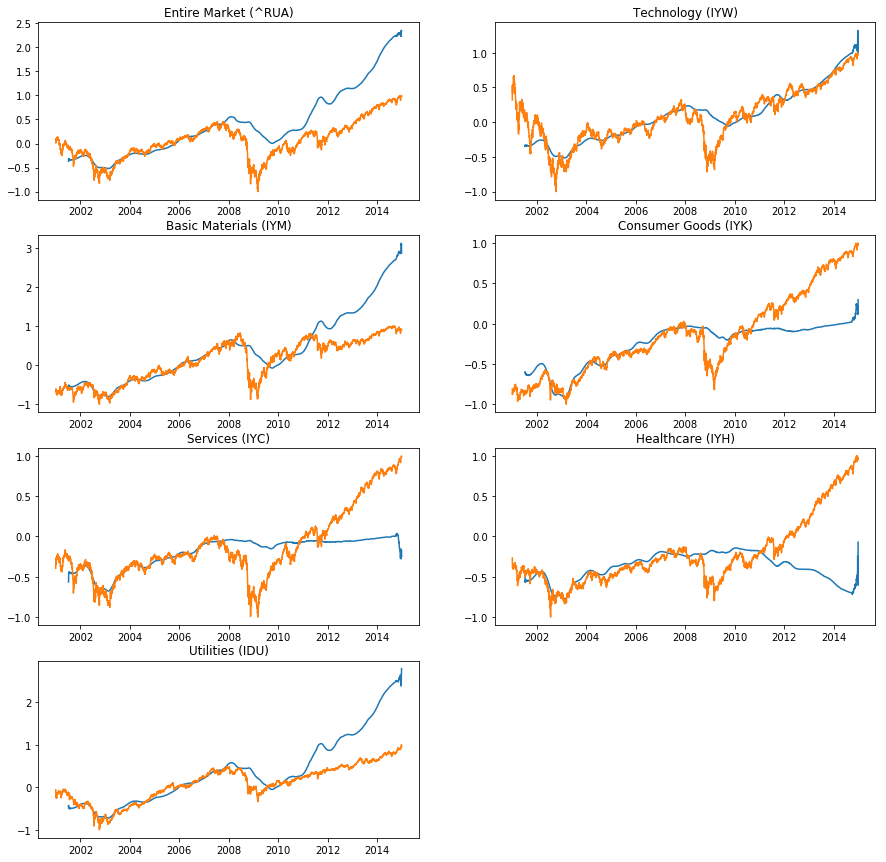

In [365]:
plt.figure(figsize=(15,15))
Nc=int(DNN.train_frac*N)
for k in range(Netf):
    plt.subplot(4,2,k+1)
    plt.plot_date(times,pred[:,k],'-',label='pred')
    plt.plot_date(times,Xsub_scale[:,ind_etf[k]],'-')#[:,ind_etf[k]])
    plt.title(df_tot.columns[ind_etf[k]])
    #plt.plot([Nc,Nc],[-1,1],'k')
plt.show()    


So this is overfitting like crazy again! A simple linear regression would work better at this point. 

In [361]:
pred.shape

(3543, 7)

756